# code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib


def sigma(altitude):
    a = 1
    b = 0.015
    return a * (1 - np.exp(-b * altitude))


def sensor_model(true_matrix, altitude):
    sig = sigma(altitude)
    P_z_equals_m = 1 - sig
    P_z_not_equals_m = sig

    rows, cols = true_matrix.shape
    observation_matrix = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            if true_matrix[i, j] == 1:
                observation_matrix[i, j] = np.random.choice(
                    [1, 0], p=[P_z_equals_m, P_z_not_equals_m]
                )
            else:
                observation_matrix[i, j] = np.random.choice(
                    [0, 1], p=[P_z_equals_m, P_z_not_equals_m]
                )

    return observation_matrix


def calculate_statistics_(true_matrix, observation):
    true_positive = np.sum((true_matrix == 1) & (observation == 1))
    false_negative = np.sum((true_matrix == 1) & (observation == 0))
    false_positive = np.sum((true_matrix == 0) & (observation == 1))
    true_negative = np.sum((true_matrix == 0) & (observation == 0))
    precision = (
        true_positive / (true_positive + false_positive)
        if (true_positive + false_positive) > 0
        else 0
    )
    recall = (
        true_positive / (true_positive + false_negative)
        if (true_positive + false_negative) > 0
        else 0
    )
    # f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # accuracy = (true_positive + true_negative) / true_matrix.size

    return {
        "True Positive": true_positive,
        "False Negative": false_negative,
        "False Positive": false_positive,
        "True Negative": true_negative,
        # 'F1 Score': f1_score,
        # 'Accuracy': accuracy
    }

In [2]:
# Sample the sensor model N times and geenrate observation matrix
def sampler(true_matrix, altitude, N):
    cumulative_observation = np.empty((0, 2))
    # cumulative_observation = np.zeros((N, rows, cols), dtype=int)
    for i in range(N):
        observation_matrix = sensor_model(true_matrix, altitude)
        cumulative_observation = np.vstack([cumulative_observation, observation_matrix])
    return cumulative_observation

In [3]:
def confusion_matrix(altitude, N, asmatrix=True):

    true_matrix = np.array([0, 1])
    true_matrix = np.expand_dims(true_matrix, axis=0)
    N0 = int(N)
    N1 = int(N)
    observation = sampler(true_matrix, altitude, int(N))
    stats = calculate_statistics_(true_matrix, observation)
    matrix_dict = {
        "S": round(sigma(altitude), 2),
        "FP": round(stats["False Positive"] / N0, 2),
        "FN": round(stats["False Negative"] / N1, 2),
        "TN": round(stats["True Negative"] / N1, 2),
        "TP": round(stats["True Positive"] / N0, 2),
        "1-S": round(1 - sigma(altitude), 2),
    }
    if asmatrix == False:
        return matrix_dict

    TP = matrix_dict["TP"]
    FP = matrix_dict["FP"]
    TN = matrix_dict["TN"]
    FN = matrix_dict["FN"]

    matrix = np.array([[TN, FN], [FP, TP]])
    return matrix


def plot_three_confusion_matrices(matrices, titles, global_title="Confusion Matrices"):
    # classes=["Positive", "Negative"]
    classes = ["0", "1"]

    if len(matrices) != 3:
        raise ValueError("Exactly three matrices must be provided.")

    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(global_title, fontsize=16)

    for idx, (matrix, ax) in enumerate(zip(matrices, axes)):
        cax = ax.matshow(matrix, cmap="Blues", alpha=0.75)

        # Annotate cells
        for (i, j), val in np.ndenumerate(matrix):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

        # Set axis labels
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)

        if idx == 0:
            ax.set_ylabel("Predicted Label")

        ax.set_xlabel("True Label")
        ax.set_title(titles[idx], fontsize=10)

    # Add a colorbar to the right of the entire set of plots
    # fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

In [2]:
import numpy as np

np.round(1.49, decimals=0)

1.0

In [4]:
# Function to calculate n
def calc_n(h, e=np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])):
    p = sigma(h)
    p_ = 1 - p
    return np.round(1.96 * 1.96 * p * p_ / e / e, decimals=0)


def group_and_select_representative(numbers, num_groups=5, tight_threshold=0.5):
    # Sort the numbers in ascending order
    sorted_numbers = sorted(numbers)

    # Determine the range of values
    min_val, max_val = min(sorted_numbers), max(sorted_numbers)

    # Calculate bin edges (ranges) on log scale
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)
    bin_edges = np.logspace(log_min, log_max, num_groups + 1)

    # Group the numbers into bins
    grouped = []
    for i in range(num_groups):
        group = [
            num for num in sorted_numbers if bin_edges[i] <= num < bin_edges[i + 1]
        ]
        if group:
            grouped.append(group)

    # Select the most representative number from each group
    representative_numbers = []
    for group in grouped:
        group_min = int(min(group))
        group_max = int(max(group))

        # Determine if the bin is tight or distant based on the logarithmic scale
        log_range = np.log10(group_max) - np.log10(group_min)
        if log_range > tight_threshold:  # Distant bin, use min and max
            representative_numbers.append((group_min, group_max))
        else:  # Tight bin, use median
            representative_numbers.append(int(np.median(group)))

    return representative_numbers


def plot_N_vs_E(altitudes, errors):
    plt.figure(figsize=(10, 6))
    all_n_values = []
    n_per_e = {}
    for h in altitudes:
        n_values = calc_n(h)
        n_per_e[h] = {e: n for e, n in zip(errors, n_values)}
        all_n_values.extend(n_values)
        plt.plot(errors, n_values, marker="o", label=f"Altitude = {h} m")

    # Select specific n-values for y-ticks
    unique_n_values = group_and_select_representative(all_n_values, num_groups=8)
    plt.yscale("log")  # Ensure logarithmic scale
    plt.yticks(
        ticks=unique_n_values, labels=[f"{val}" for val in unique_n_values], fontsize=6
    )  # Apply ticks

    # Add labels and legend
    plt.xlabel("Error Tolerance (e)")
    plt.ylabel("Sample Size (n)")
    plt.title("Sample Size vs. Error Tolerance for Different Altitudes")
    # plt.xscale('log')  # Log scale for error tolerance
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()
    return n_per_e

In [5]:
def plot_conf_vs_N(all_data):
    altitudes = list(all_data.keys())
    n_altitudes = len(altitudes)

    # Create subplots with 2 columns
    n_cols = 2
    n_rows = (n_altitudes + 1) // n_cols
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(10, 3 * n_rows), sharex=False, sharey=False
    )

    # Flatten axes for easier indexing if more than one row is present
    axes = axes.flatten() if n_altitudes > 1 else [axes]

    for idx, altitude in enumerate(altitudes):
        samples = all_data[altitude]
        sample_numbers = sorted(samples.keys())

        # Extract values for FP, FN, S, TP, TN, and 1-S
        FP = [samples[n]["FP"] for n in sample_numbers]
        FN = [samples[n]["FN"] for n in sample_numbers]
        S = [samples[n]["S"] for n in sample_numbers]
        TP = [samples[n]["TP"] for n in sample_numbers]
        TN = [samples[n]["TN"] for n in sample_numbers]
        one_minus_S = [samples[n]["1-S"] for n in sample_numbers]

        # Plot FP, FN, S, TP, TN, and 1-S
        ax = axes[idx]
        ax.plot(sample_numbers, FP, label="FP", marker="o")
        ax.plot(sample_numbers, FN, label="FN", marker="o")
        ax.plot(sample_numbers, S, label="S")
        ax.plot(sample_numbers, TP, label="TP", marker="o")
        ax.plot(sample_numbers, TN, label="TN", marker="o")
        ax.plot(sample_numbers, one_minus_S, label="1-S")

        ax.set_title(f"Altitude: {altitude}")
        ax.set_ylabel("Value")
        ax.set_xlabel("Samples")
        ax.grid(True)
        ax.legend(loc="best")

    # Remove unused subplots if the number of altitudes is less than the grid size
    for idx in range(len(altitudes), len(axes)):
        fig.delaxes(axes[idx])

    # Set a common x-label and adjust layout
    plt.tight_layout()
    plt.show()

# plots

In [21]:
# altitudes = [5.41, 10.83, 16.24, 21.65, 27.06, 32.48]
# start = 6.49519052838329
start = 5.41
num_values = 6
end = num_values * start


altitudes = np.round(np.linspace(start, end, num=num_values), decimals=0)

print(altitudes)

[ 5. 11. 16. 22. 27. 32.]


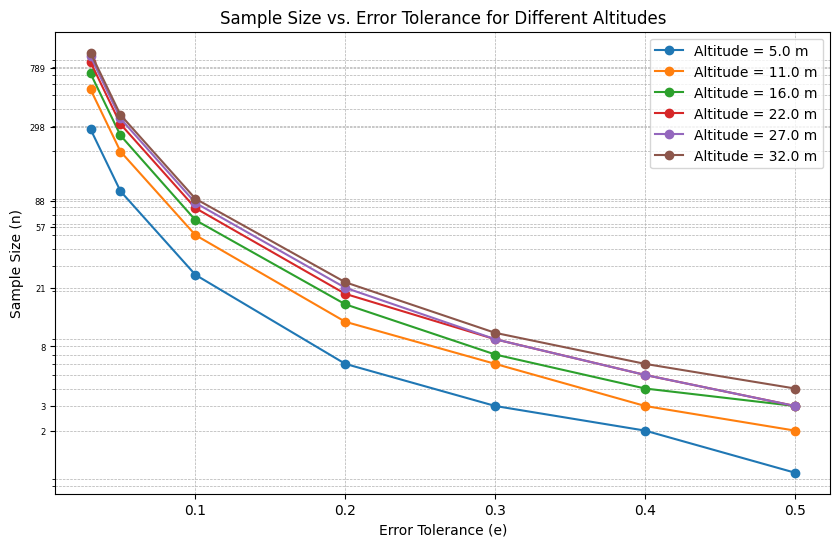

In [22]:
errors = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])
n_per_e = plot_N_vs_E(altitudes, errors)

In [23]:
n_per_e

{5.0: {0.5: 1.0,
  0.4: 2.0,
  0.3: 3.0,
  0.2: 6.0,
  0.1: 26.0,
  0.05: 103.0,
  0.03: 286.0},
 11.0: {0.5: 2.0,
  0.4: 3.0,
  0.3: 6.0,
  0.2: 12.0,
  0.1: 50.0,
  0.05: 198.0,
  0.03: 551.0},
 16.0: {0.5: 3.0,
  0.4: 4.0,
  0.3: 7.0,
  0.2: 16.0,
  0.1: 64.0,
  0.05: 258.0,
  0.03: 716.0},
 22.0: {0.5: 3.0,
  0.4: 5.0,
  0.3: 9.0,
  0.2: 19.0,
  0.1: 78.0,
  0.05: 311.0,
  0.03: 863.0},
 27.0: {0.5: 3.0,
  0.4: 5.0,
  0.3: 9.0,
  0.2: 21.0,
  0.1: 85.0,
  0.05: 341.0,
  0.03: 948.0},
 32.0: {0.5: 4.0,
  0.4: 6.0,
  0.3: 10.0,
  0.2: 23.0,
  0.1: 91.0,
  0.05: 362.0,
  0.03: 1007.0}}

In [24]:
import json

with open("/home/bota/Desktop/active_sensing/data/N_per_E.json", "w") as file:
    json.dump(n_per_e, file, indent=4)

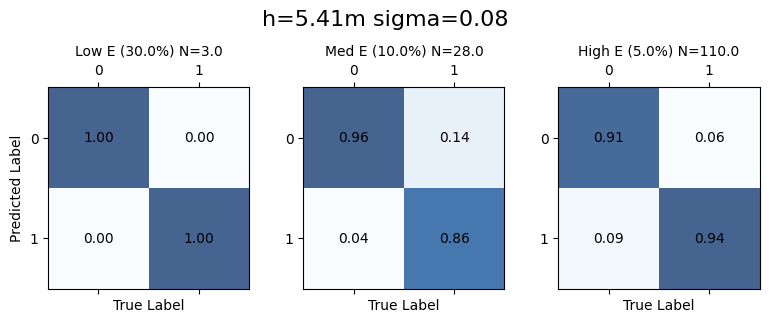

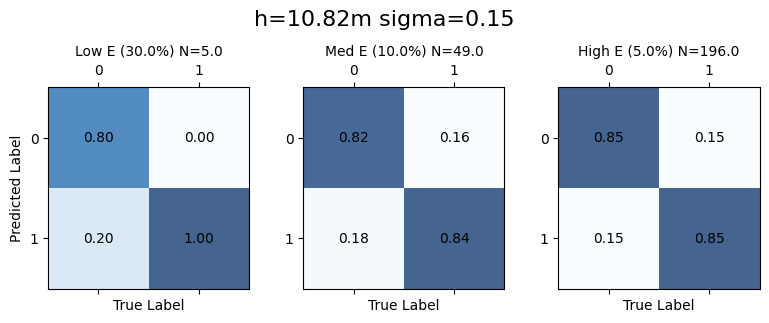

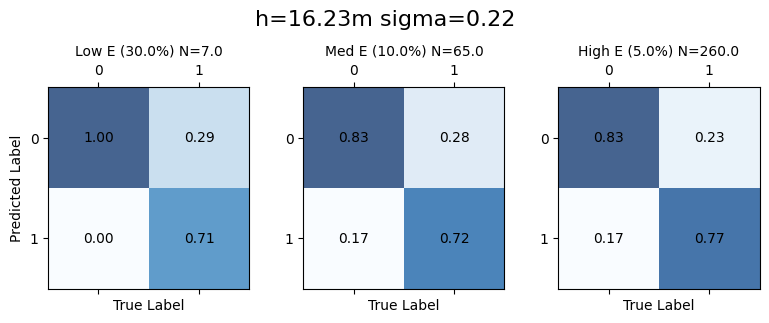

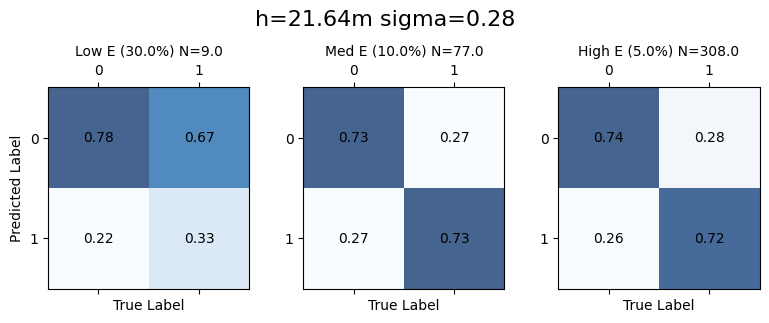

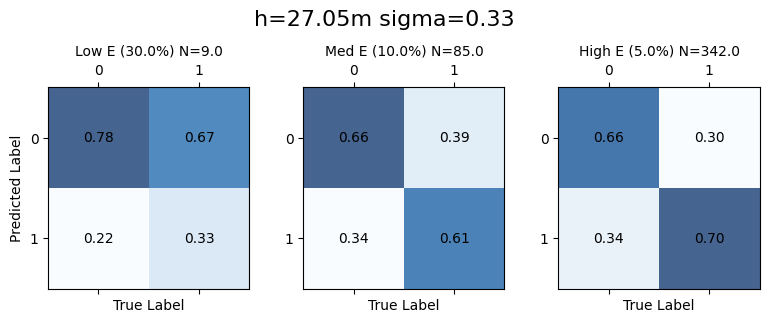

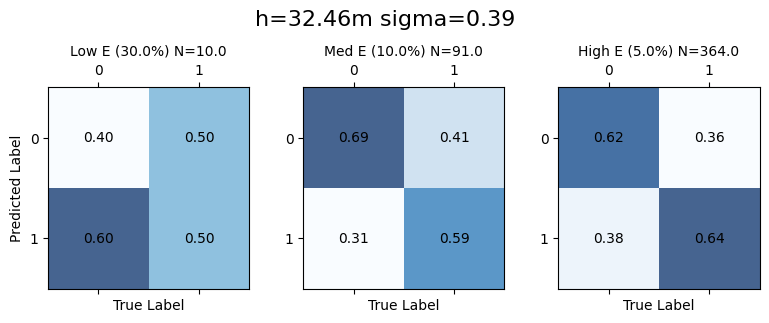

In [16]:
# errors = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])
low = 0.3
medium = 0.1
high = 0.05

for h in altitudes:
    N_low = n_per_e[h][low]
    N_med = n_per_e[h][medium]
    N_high = n_per_e[h][high]
    conf_low = confusion_matrix(h, N_low)
    conf_med = confusion_matrix(h, N_med)
    conf_high = confusion_matrix(h, N_high)
    global_title = f"h={h}m sigma={sigma(h):.2f}"
    titles = [
        f"Low E ({low*100}%) N={N_low}",
        f"Med E ({medium*100}%) N={N_med}",
        f"High E ({high*100}%) N={N_high}",
    ]
    plot_three_confusion_matrices(
        [conf_low, conf_med, conf_high], titles, global_title=global_title
    )
    # break

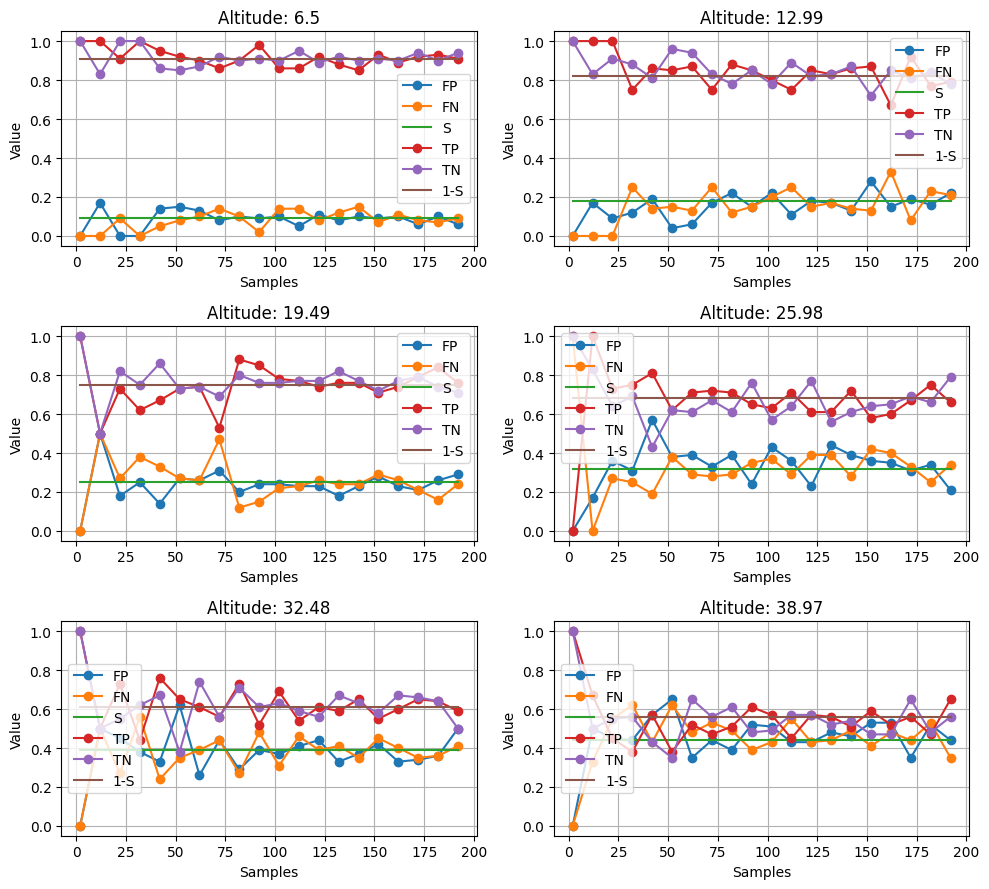

In [11]:
N_max = 200
N_values = list(range(1, N_max + 1, 5))
N_values = N_values[0 : int(len(N_values) / 2)]

all_data = {}
for i, altitude in enumerate(altitudes):
    all_data[altitude] = {}
    for N in N_values:
        all_data[altitude][2 * N] = confusion_matrix(altitude, N, asmatrix=False)

plot_conf_vs_N(all_data)